### Import packages

In [1]:
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from flask import Flask, request, jsonify
from datetime import datetime, timedelta
from pmdarima.arima import auto_arima
from matplotlib import pyplot
from numpy import sqrt 
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
import re

import warnings
warnings.filterwarnings("ignore")

***

## 1. Ingestion

### Scraping the data

In [2]:
url= 'https://www.worldometers.info/coronavirus/country/south-africa/'

page = requests.get(url)
soup = BeautifulSoup(page.text, "html.parser")

all_scripts = soup.find_all('script')

for number, script in enumerate(all_scripts):
    if 'graph-active-cases-total' in script.text:
        hcText = script.text

# Get the x values using regular expression
pattern = r"data:\s*\[(.*?)\]"
match_x = re.search(pattern, hcText, re.DOTALL)

if match_x:
    data_str_x = match_x.group(1)
    data_list_x = json.loads("[" + data_str_x + "]")
else:
    print("Data array not found.")

# Get the y values using regular expression
pattern = r"categories:\s*\[(.*?)\]"
match_y = re.search(pattern, hcText, re.DOTALL)

if match_y:
    data_str_y = match_y.group(1)
    data_list_y = json.loads("[" + data_str_y + "]")
else:
    print("Data array not found.")

### Create a dataframe with the data

In [3]:
d = {'Day': data_list_y, 'Cases': data_list_x}
cases = pd.DataFrame(data=d)
cases

,Day,Cases
0,"Feb 15, 2020",0
1,"Feb 16, 2020",0
2,"Feb 17, 2020",0
3,"Feb 18, 2020",0
4,"Feb 19, 2020",0
...,...,...
1502,"Mar 27, 2024",61362
1503,"Mar 28, 2024",61362
1504,"Mar 29, 2024",61362
1505,"Mar 30, 2024",61362


### Plot the data 

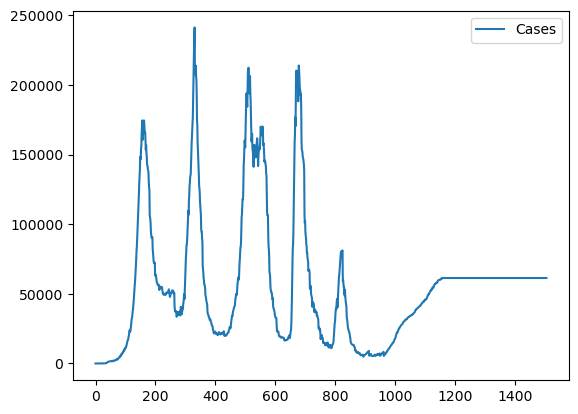

In [4]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt

# Plot and show the time series on axis ax1
fig, ax1 = plt.subplots()
cases.plot(ax=ax1)
plt.show()

***

## 2. Modelling

### Split the data

In [5]:
# Split the data into a train and test set
X_train, X_test = train_test_split(data_list_x, test_size=0.34, random_state=42)
history = [x for x in X_train]

### Check if it is stationary

In [6]:
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

# Run test
result = adfuller(cases['Cases'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])

# Print critical values
print(result[4]) 

-4.970807229452105
2.534294505675779e-05
{'1%': -3.43476120520139, '5%': -2.863488262178673, '10%': -2.567807233388883}


#### Since there is a very low p value, can conclude that it is indeed stationary.

### Auto Correlation Plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

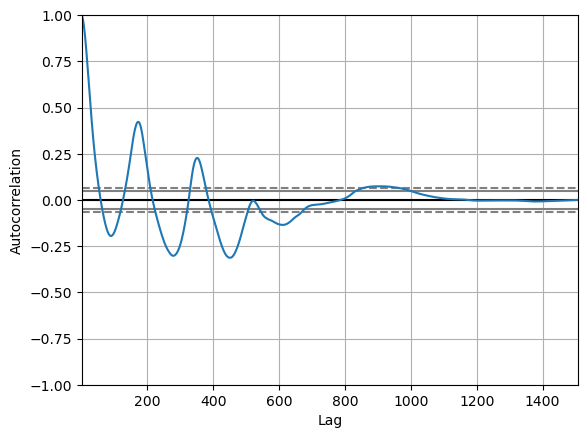

In [7]:
autocorrelation_plot(cases['Cases'])

### Partial Autocorrelation Graph

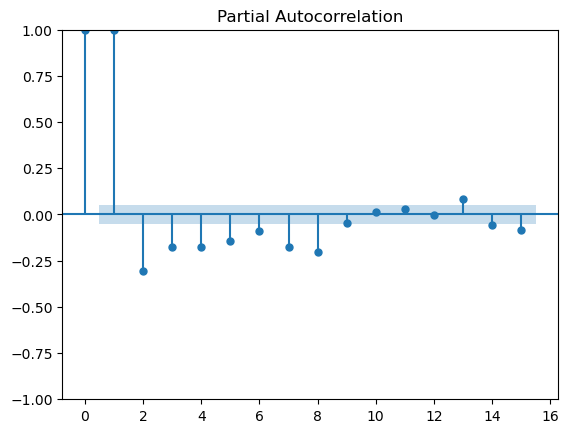

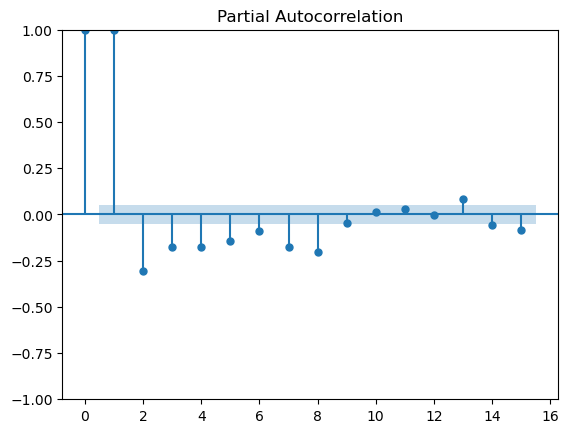

In [8]:
plot_pacf(cases['Cases'], lags=15)

### Use Auto Arima

In [9]:
# Use "Auto Arima" to get the best hyperparameters
model = auto_arima(X_train, 
                   start_p=1, 
                   start_q=1,
                   test='adf',
                   max_p=5, 
                   max_q=5,
                   m=1,             
                   d=1,          
                   seasonal=False,   
                   start_P=0, 
                   D=None, 
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25016.074, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24696.247, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25014.075, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24584.157, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24511.250, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=24461.024, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=24427.180, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=24316.775, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=24311.748, Time=0.66 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=24310.679, Time=0.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24309.985, Time=0.46 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   :

### Fit the ARIMA Model

In [10]:
# Get today's date
today = datetime.today()

# List to store the next 7 days as strings
next_seven_days = []

# Loop through the next 7 days
for i in range(1,8):
    # Calculate the date for the next day
    next_day = today + timedelta(days=i)
    # Format the date as a string in the 'Feb 15, 2020' format
    next_seven_days.append(next_day.strftime('%b %d, %Y'))

# Print the list of next 7 days as strings
print(next_seven_days)

['Apr 02, 2024', 'Apr 03, 2024', 'Apr 04, 2024', 'Apr 05, 2024', 'Apr 06, 2024', 'Apr 07, 2024', 'Apr 08, 2024']


In [11]:
model = ARIMA(history, order=(2,1,2))
model_fit = model.fit()
output = model_fit.forecast(7)
output

array([57126.70671811, 56878.03331996, 56984.28815932, 56892.01036904,
       56977.97044158, 56897.53993982, 56972.81682693])

***

## 3. Simple Reporting

### Data to CSV

In [12]:
data = {'Date': next_seven_days, 'new_cases': output}

df = pd.DataFrame(data)

df.to_csv('data.csv', index=False)

### Time Series Plot

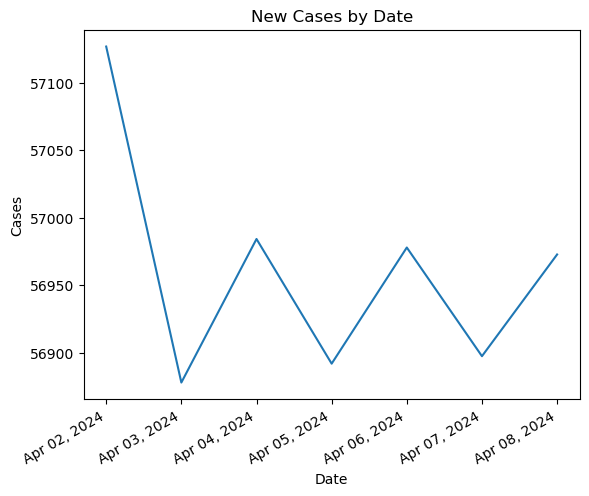

In [13]:
import matplotlib.pyplot as plt

# Plotting the time series of given dataframe
plt.plot(df.Date, df.new_cases)

# Giving title to the chart using plt.title
plt.title('New Cases by Date')
 
# rotating the x-axis tick labels at 30degree 
# towards right
plt.xticks(rotation=30, ha='right')
 
# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Cases')

# Saving the figure.
plt.savefig("new_cases_by_date.png", bbox_inches='tight')

### Walk forward validation

predicted=57126.706718, expected=83985.000000
predicted=55791.520586, expected=60000.000000
predicted=56512.267391, expected=31330.000000
predicted=58270.085374, expected=63004.000000
predicted=56794.584225, expected=6349.000000
predicted=58820.395402, expected=61362.000000
predicted=57574.191329, expected=139045.000000
predicted=52664.640276, expected=41600.000000
predicted=57320.342754, expected=84487.000000
predicted=56338.317320, expected=45984.000000
predicted=56594.677035, expected=61362.000000
predicted=57773.617795, expected=61362.000000
predicted=55827.322117, expected=103496.000000
predicted=55943.594477, expected=9542.000000
predicted=57600.852620, expected=11422.000000
predicted=60920.686958, expected=61362.000000
predicted=55441.120027, expected=27283.000000
predicted=59371.690213, expected=5547.000000
predicted=58271.841556, expected=50111.000000
predicted=58526.849237, expected=12023.000000
predicted=57431.508727, expected=152965.000000
predicted=54491.123682, expected=5

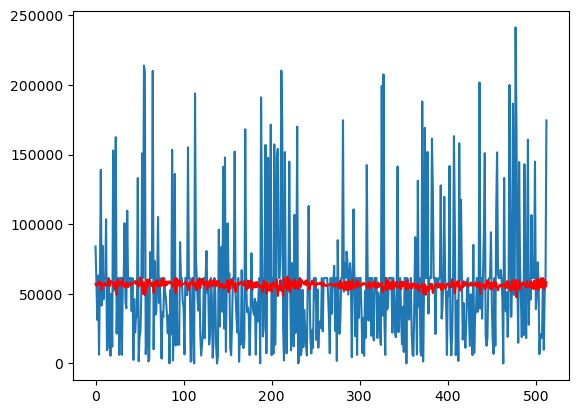

In [14]:
# walk-forward validation
predictions = []
for t in range(len(X_test)):
 model = ARIMA(history, order=(2,1,2))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = X_test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(X_test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(X_test)
pyplot.plot(predictions, color='red')
pyplot.show()

***